In [1]:
import os
import tensorflow as tf
import cv2 as cv
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from ipynb.fs.full.preProcess import basic_preProcess, category_preProcess
from sklearn.cluster import KMeans

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization,Conv2D,MaxPooling2D,Activation,Dropout,Lambda,Dense,Flatten, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.callbacks import EarlyStopping


from keras.utils.vis_utils import plot_model

In [2]:
# For Google Colab:
# from google.colab import drive
# drive.mount('/content/drive')

# train_dir = '/content/drive/MyDrive/Data/train'
# test_dir = '/content/drive/MyDrive/Data/test'
# train_df = pd.read_csv('/content/drive/MyDrive/Data/train.csv')

In [3]:
# For Local File:
train_dir = './train/'
test_dir = './test/'
train_df = pd.read_csv('./train.csv')

In [4]:
train_data_category = []

train_jenis = []
train_warna =[]

test_data = []
test_ids = []

input_shape = (224, 224, 3)
for i in os.listdir(train_dir):
    if(i is not None):
        img_path = os.path.join(train_dir, i)
        img = cv.imread(img_path)
        if(img is not None):

          img = basic_preProcess(img)
          img_category = category_preProcess(img)

          # plot_image(img_color)
          # break

          train_data_category.append(img_category)

          cond = train_df['id'] == int(i[:-4])
          idx = train_df.loc[cond].index[0]
          train_jenis.append(train_df.iloc[idx]['jenis'])
          train_warna.append(train_df.iloc[idx]['warna'])
        else:
          print("no image found")

for i in os.listdir(test_dir):
    if(i is not None):
      img_path = os.path.join(test_dir, i)
      img = cv.imread(img_path)
      if(img is not None):
        img = basic_preProcess(img)
        test_data.append(img)
        test_ids.append(i[:-4])
      else:
        print("no image found")

xtrain_jenis, xval_jenis, ytrain_jenis, yval_jenis = train_test_split(
    train_data_category, train_jenis,
    test_size=0.2, random_state=42,
    stratify=train_jenis  
)

In [5]:
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,include_top=False,weights='imagenet')
base_model.trainable = False
# base_model.summary()

def create_model_jenis(num_classes_jenis):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Feature extraction layer
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)

    # Category branch
    category_output = layers.Dense(num_classes_jenis, activation='softmax', name='category_output')(x)

    model = Model(inputs=base_model.input, outputs=category_output)
    return model

In [6]:
input_shape = (224, 224, 3)

num_classes_jenis = len(np.unique(train_jenis))
num_classes_warna = len(np.unique(train_warna))

train_warna_categorical = to_categorical(train_warna, num_classes=num_classes_warna)
train_jenis_categorical = to_categorical(train_jenis, num_classes=num_classes_jenis)

ytrain_jenis = to_categorical(ytrain_jenis, num_classes=num_classes_jenis)
yval_jenis = to_categorical(yval_jenis, num_classes=num_classes_jenis)
# ytrain_warna = to_categorical(ytrain_warna, num_classes=num_classes_warna)
# yval_warna = to_categorical(yval_warna, num_classes=num_classes_warna)

# xtrain_warna = np.array(xtrain_warna)
# xval_warna = np.array(xval_warna)
xtrain_jenis = np.array(xtrain_jenis)
xval_jenis = np.array(xval_jenis)

inp_color = Input(shape=input_shape)
inp_category = Input(shape=input_shape)

# colorBranch = ColorNet(input=inp_color, nb_class=num_classes_warna)

print("Color model categorical labels (train_warna_categorical):", train_warna_categorical)
print("Jenis model categorical labels (train_jenis_categorical):", train_jenis_categorical)


Color model categorical labels (train_warna_categorical): [[0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 ...
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]
Jenis model categorical labels (train_jenis_categorical): [[0. 1.]
 [0. 1.]
 [1. 0.]
 ...
 [1. 0.]
 [0. 1.]
 [0. 1.]]


In [7]:
category_model = create_model_jenis(num_classes_jenis)

In [10]:
# Train Category Model
opt = Adam(learning_rate=0.0005)

category_model.compile(optimizer=opt, loss='categorical_crossentropy',
	metrics=['accuracy'])

history = category_model.fit(xtrain_jenis,ytrain_jenis, batch_size= 16, epochs=50,validation_data=(xval_jenis,yval_jenis))

Epoch 1/50
39/39 [==============================] - 5s 75ms/step - loss: 0.0400 - accuracy: 0.9903 - val_loss: 7.6257 - val_accuracy: 0.6603
Epoch 2/50
39/39 [==============================] - 3s 64ms/step - loss: 0.0101 - accuracy: 0.9952 - val_loss: 16.6731 - val_accuracy: 0.6154
Epoch 3/50
39/39 [==============================] - 2s 64ms/step - loss: 0.0461 - accuracy: 0.9903 - val_loss: 2.9281 - val_accuracy: 0.8205
Epoch 4/50
39/39 [==============================] - 2s 61ms/step - loss: 0.0073 - accuracy: 0.9984 - val_loss: 1.7730 - val_accuracy: 0.8141
Epoch 5/50
39/39 [==============================] - 2s 61ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 1.2266 - val_accuracy: 0.8590
Epoch 6/50
39/39 [==============================] - 2s 61ms/step - loss: 0.0340 - accuracy: 0.9887 - val_loss: 1.8787 - val_accuracy: 0.7500
Epoch 7/50
39/39 [==============================] - 2s 63ms/step - loss: 0.1292 - accuracy: 0.9694 - val_loss: 8.6343 - val_accuracy: 0.4167
Epoch 8/50
3

20/20 [==============================] - 1s 31ms/step - loss: 5.0505e-07 - accuracy: 1.0000
Loss and metrics for each output: [5.050450226917746e-07, 1.0]
Total Test Loss: 5.050450226917746e-07
Category Accuracy: 1.0
5/5 [==============================] - 0s 27ms/step - loss: 0.7801 - accuracy: 0.9423
Loss and metrics for each output: [0.7800832986831665, 0.942307710647583]
Total Vall Loss: 0.7800832986831665
Val Category Accuracy: 0.942307710647583


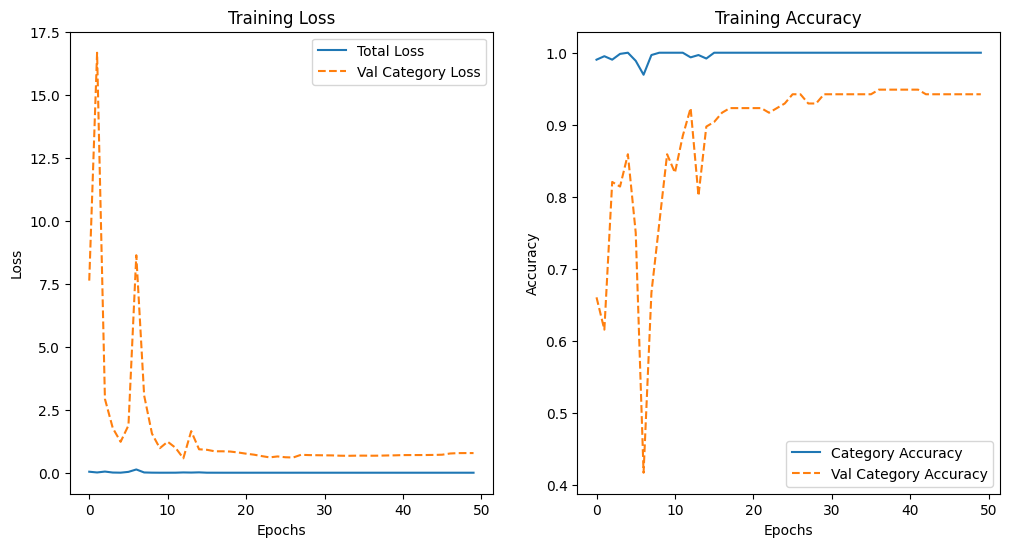

In [11]:
# View Category Model Metrics
score = category_model.evaluate(xtrain_jenis,ytrain_jenis)
print("Loss and metrics for each output:", score)
print('Total Test Loss:', score[0])
print('Category Accuracy:', score[1])

score = category_model.evaluate(xval_jenis,yval_jenis)
print("Loss and metrics for each output:", score)
print('Total Vall Loss:', score[0])
print('Val Category Accuracy:', score[1])

totall = len(history.history['loss'])

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(totall), history.history['loss'], label='Total Loss')
plt.plot(range(totall), history.history['val_loss'], label='Val Category Loss', linestyle='--')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')

plt.subplot(1, 2, 2)
plt.plot(range(totall), history.history['accuracy'], label='Category Accuracy')

plt.plot(range(totall), history.history['val_accuracy'], label='Val Category Accuracy', linestyle='--')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')

plt.show()

In [13]:
category_model.save('./models/category.h5', include_optimizer=True)